In [ ]:
import os

import numpy as np
import cv2

from keras.models import load_model
from sklearn.neighbors import NearestNeighbors
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload facenet model and verify model existence

In [ ]:
# - Model input shape: [160, 160, 3]
# - Model output shape: [128]
SAVED_MODEL_PATH = '/content/drive/MyDrive/258 Project/model/facenet_keras.h5'
assert os.path.exists(SAVED_MODEL_PATH)

EMB_DIM = 128

In [ ]:
class FaceNet:
  def __init__(self):
    self.model = load_model(SAVED_MODEL_PATH, compile=False)

  def _load_image(self, image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (160, 160))
    image = image.astype('float') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

  def predict_embedding(self, image_path):
    image = self._load_image(image_path)
    return self.model.predict(image)[0]

In [ ]:
class FaceRecognizer:
  def __init__(self, facenet):
    self.facenet = facenet
    self.nn = NearestNeighbors(n_neighbors=3, metric='l2', algorithm='brute')
    self.face_matrix = None
    self.face_index = None # index to label


  # Image file name will be used as label.
  # E.g. `elon_mask` will be the label for image  `/path/to/elon_mask.jpeg` 
  def build_face_database(self, image_paths):
    self.face_matrix = np.zeros([len(image_paths), EMB_DIM], dtype=float)
    self.face_index = [None] * len(image_paths)
    for i, fp in enumerate(image_paths):
      if not os.path.exists(fp):
        print(f'[Error] image {fp} does not exist.')
        return

      print(f'Processing image {fp}...')
      label = os.path.basename(fp).split('.')[0]
      emb = self.facenet.predict_embedding(fp)
      self.face_matrix[i, :] = emb
      self.face_index[i] = label
      print(f'Added image {fp} to database with label {label}.')

    print(f'Matrix shape: {self.face_matrix.shape}')
    self.nn.fit(self.face_matrix)


  # Return label and distance
  def recognize(self, image_path):
    if not os.path.exists(image_path):
        print(f'[Error] image {image_path} does not exist.')
        return
    emb = self.facenet.predict_embedding(image_path)
    emb = np.expand_dims(emb, axis=0)
    dists, inds = self.nn.kneighbors(emb)
    for i, d in zip(inds[0], dists[0]):
      print(f'{self.face_index[i]} -> {d}')
    label = self.face_index[inds[0][0]]
    return label, dists[0][0]


  

In [ ]:
facenet = FaceNet()

In [ ]:
recognizer = FaceRecognizer(facenet)

In [ ]:
recognizer.build_face_database(glob.glob('/content/drive/MyDrive/258 Project/face_dataset/*'))

Processing image /content/drive/MyDrive/258 Project/face_dataset/Aaron_Sorkin.jpg...
1/1 [==============================] - 9s 9s/step
Added image /content/drive/MyDrive/258 Project/face_dataset/Aaron_Sorkin.jpg to database with label Aaron_Sorkin.
Processing image /content/drive/MyDrive/258 Project/face_dataset/elon_mask.jpeg...
1/1 [==============================] - 0s 25ms/step
Added image /content/drive/MyDrive/258 Project/face_dataset/elon_mask.jpeg to database with label elon_mask.
Processing image /content/drive/MyDrive/258 Project/face_dataset/jeff_bezos.jpeg...
1/1 [==============================] - 0s 28ms/step
Added image /content/drive/MyDrive/258 Project/face_dataset/jeff_bezos.jpeg to database with label jeff_bezos.
Processing image /content/drive/MyDrive/258 Project/face_dataset/larry_page.jpeg...
1/1 [==============================] - 0s 30ms/step
Added image /content/drive/MyDrive/258 Project/face_dataset/larry_page.jpeg to database with label larry_page.
Processing im

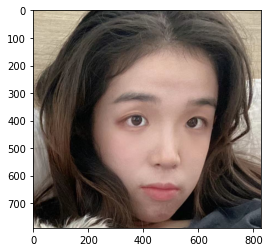

In [ ]:
query_image = '/content/drive/MyDrive/258 Project/face_query_set/xialu1.jpg'

imgplot = plt.imshow(mpimg.imread(query_image))
plt.show()

In [ ]:
label, dist = recognizer.recognize(query_image)
print(f'This is {label}')

1/1 [==============================] - 0s 27ms/step
xialu -> 6.840508712064196
Aaron_Sorkin -> 9.037030135254957
jie -> 9.652046421142138
This is xialu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
